In [43]:
import pandas as pd
import numpy as np
import re
import glob
import re
import nltk
from nltk.tokenize import RegexpTokenizer
import zipfile
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
liwc2 = pd.read_excel('/home_remote/dic_avg100_annotated_official.xlsx')
liwc2['Terms'] = liwc2['Term'].apply(lambda x: ast.literal_eval(x))
result = dict(zip(liwc2['Category'], liwc2['Terms']))

In [45]:
def parse_dict(_dict):
    '''
    param: dictionary with key as categorie and value as the list of words
    return: a lexicon with key as word and values as the list of categories the word belongs to.
    '''
    lt =[]
    for x in _dict.values():
        lt = lt+x
    mylist = [*set(lt)]
    lexicon = {}
    for i in mylist:
        ls = []
        for j in _dict.keys():
            #print(j)
            if i in _dict[j]:
                ls.append(j)
        lexicon[i] = ls
    return lexicon, list(_dict.keys())
    

In [46]:
# ref: https://github.com/chbrown/liwc-python
def build_trie(lexicon):
    """
    A `*` indicates a wildcard match.
    """
    trie = {}
    for pattern, category_names in lexicon.items():
        cursor = trie
        for char in pattern:
            if char == "*":
                cursor["*"] = category_names
                break
            if char not in cursor:
                cursor[char] = {}
            cursor = cursor[char]
        cursor["$"] = category_names
    return trie

In [47]:
#ref: https://github.com/chbrown/liwc-python
def search_trie(trie, token, token_i=0):
    if "*" in trie:
        return trie["*"]
    if "$" in trie and token_i == len(token):
        return trie["$"]
    if token_i < len(token):
        char = token[token_i]
        if char in trie:
            return search_trie(trie[char], token, token_i + 1)
    return []

In [48]:
# ref: https://github.com/chbrown/liwc-python
def load_token_parser(dic):
    lexicon, category_names = parse_dict(dic)
    trie = build_trie(lexicon)

    def parse_token(token):
        for category_name in search_trie(trie, token):
            yield category_name

    return parse_token, category_names

In [49]:
def tokenize(text):
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    for match in tokenizer.tokenize(text) :
        yield match

In [50]:
def main(input_, result):
   # dic['Terms'] = dic['Term'].apply(lambda x: ast.literal_eval(x))
   # result = dict(zip(dic['Category'], dic['Terms']))
    #lexicon = parse_dict(result)
    parse, category_names = load_token_parser(result)
    input_tokens = tokenize(input_.lower())
    counts = Counter(category for token in input_tokens for category in parse(token))
    
#   a = pd.DataFrame.from_dict(dict(counts),orient = 'index').reset_index()
#   a= a.rename(columns={"index": "Category", 0: "Count"})
#   a['Percentage(%)']= round(a['Count']/len(input_.split(' '))*100,2)
    return counts

# LIWC alike

In [51]:
# Load data
%store -r df
%store -r df_neg

In [52]:
#combine Text and Title
df['Text_Title'] = df['Title'] + '.' + df['Text']
df_neg['Text_Title'] = df_neg['Title'] + '.' + df_neg['Text']
#combine all text of same user into one string
text_per_user_pos = df.groupby('User')['Text_Title'].apply(' '.join).reset_index()
text_per_user_neg = df_neg.groupby('User')['Text_Title'].apply(' '.join).reset_index()
#add label
text_per_user_pos['label'] = 1
text_per_user_neg['label'] = 0

In [53]:
# input text to LIWC-alike
liwc_pos = [main(text, result) for text in text_per_user_pos['Text_Title']]
liwc_neg = [main(text, result) for text in text_per_user_neg['Text_Title']]
#then buid a dictionary with key as user, value as a list of LIWC features
liwc_pos_dict = {}
liwc_neg_dict = {}
for i in range(len(liwc_pos)):
    liwc_pos_dict[text_per_user_pos['User'][i]] = liwc_pos[i]
for i in range(len(liwc_neg)):
    liwc_neg_dict[text_per_user_neg['User'][i]] = liwc_neg[i]


In [54]:
#calculate percentage of each LIWC feature per user
liwc_pos_percent = {}
liwc_neg_percent = {}
for key, value in liwc_pos_dict.items():
    liwc_pos_percent[key] = {k: v / sum(value.values()) for k, v in value.items()}
for key, value in liwc_neg_dict.items():
    liwc_neg_percent[key] = {k: v / sum(value.values()) for k, v in value.items()}

In [55]:
#correlation of LIWC features with label
liwc_pos_percent_df = pd.DataFrame(liwc_pos_percent).T
liwc_neg_percent_df = pd.DataFrame(liwc_neg_percent).T
liwc_pos_percent_df['label'] = 1
liwc_neg_percent_df['label'] = 0
liwc_percent_df = pd.concat([liwc_pos_percent_df, liwc_neg_percent_df])
#liwc_percent_df = liwc_percent_df.fillna(0)
corr = liwc_percent_df.corr()

In [56]:
#choose the top 15 most correlated features to label
corr_label = corr['label'].sort_values(ascending=False)
corr_label = corr_label[1:16]
corr_label

I                      0.383566
Anxiety                0.341095
Sadness                0.333895
Affective Processes    0.321758
Health                 0.293504
Social Processes       0.283762
Negative Emotions      0.271239
Insight                0.183041
Tentative              0.174082
Feeling                0.171215
Sexuality              0.157296
Cognitive Processes    0.150183
Humans                 0.149557
Friends                0.148498
Family                 0.146090
Name: label, dtype: float64

In [57]:
#get the name of top 15 features
liwc_features = list(corr_label.index)
#concat with label
liwc_features.append('label')

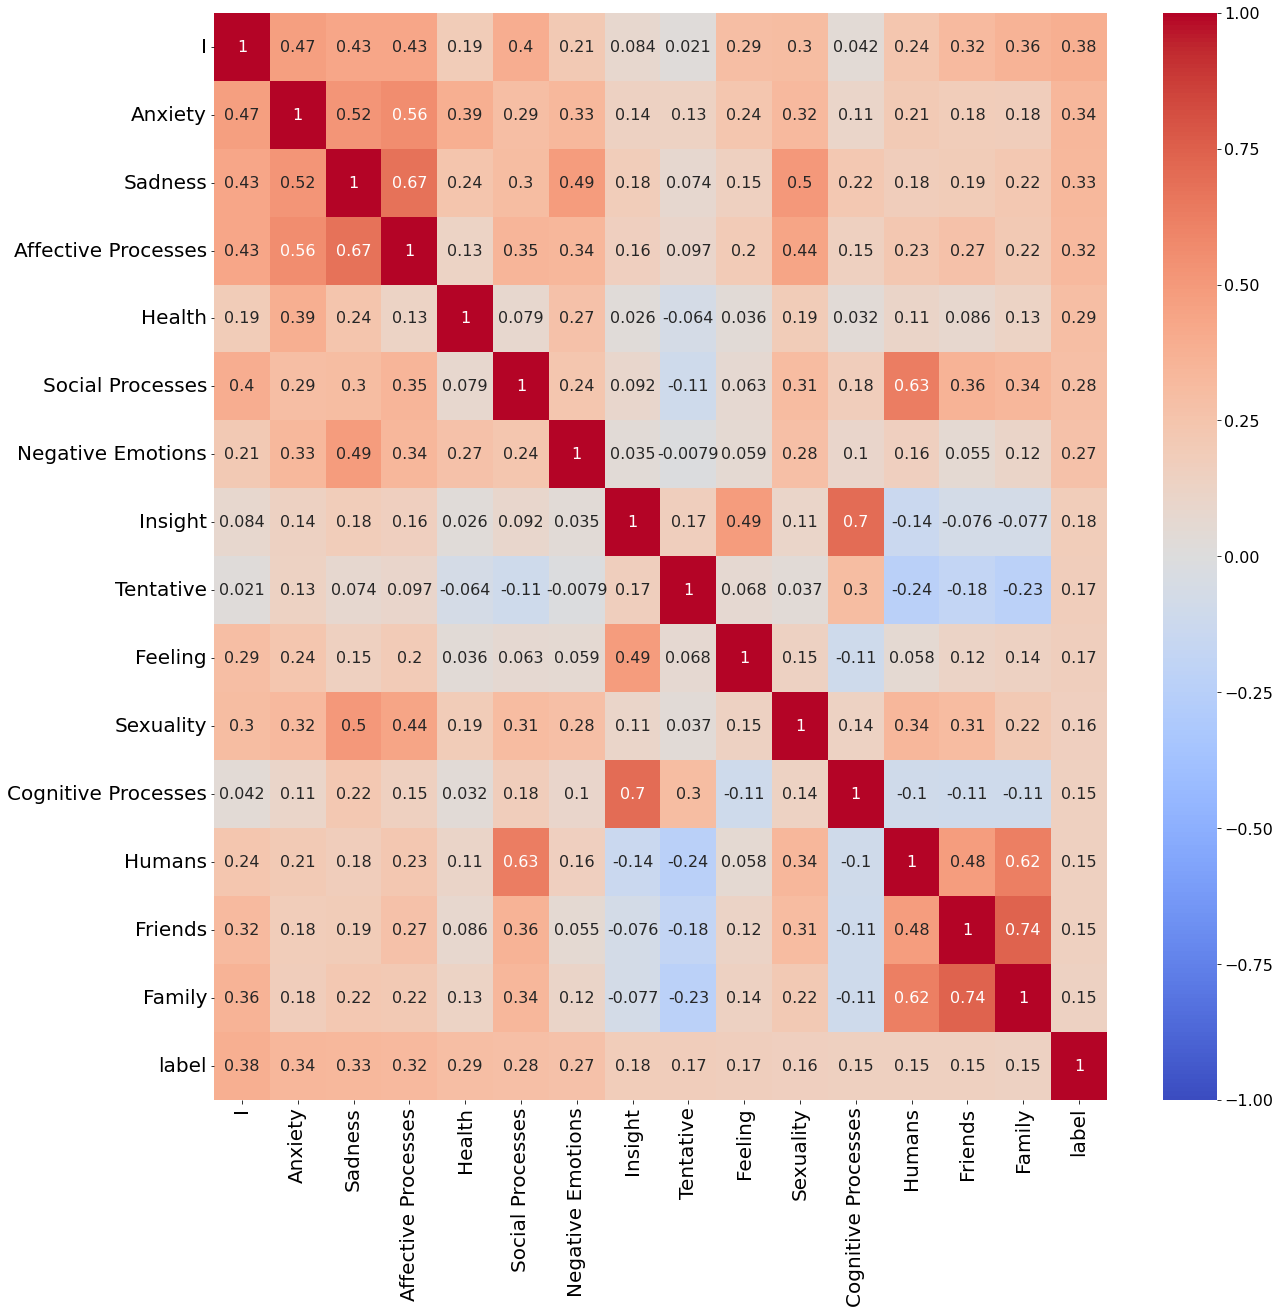

In [61]:
plt.figure(figsize=(20,20))

corr_liwc = liwc_percent_df[liwc_features].corr()
sns.heatmap(corr_liwc, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
#change font size
plt.tick_params(axis='both', which='major', labelsize=20)
#save plot to pdf
plt.savefig('/home_remote/liwc2_heatmap.pdf')

In [62]:
%store corr_label

Stored 'corr_label' (Series)
